# Plug and play prior

https://engineering.purdue.edu/~bouman/Plug-and-Play/webdocs/GlobalSIP2013a.pdf

Use bm3d: https://pypi.org/project/bm3d/

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pylops
import pyproximal

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.optimization.segmentation import Segment

np.random.seed(0)

(-0.5, 169.5, 194.5, -0.5)

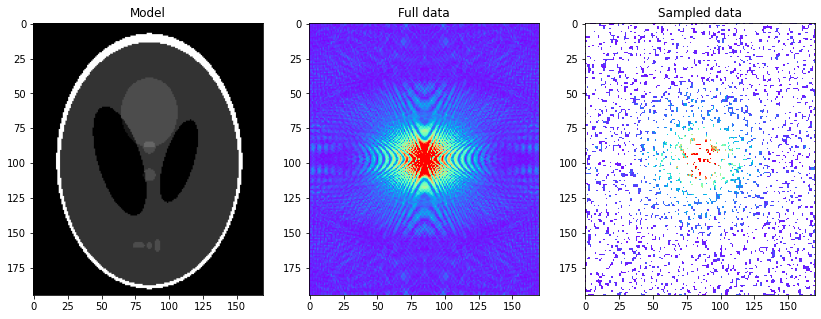

In [2]:
x = np.load("../data/optimization/shepp_logan_phantom.npy")
x = x / x.max()
ny, nx = x.shape

perc_subsampling = 0.6
nxsub = int(np.round(ny * nx * perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(ny * nx))[:nxsub])
Rop = pylops.Restriction(ny * nx, iava, dtype=np.complex128)
Fop = pylops.signalprocessing.FFT2D(dims=(ny, nx))

n = np.random.normal(0, 0.0, (ny, nx))
y = Rop * Fop * (x.ravel() + n.ravel())
yfft = Fop * (x.ravel() + n.ravel())
yfft = np.fft.fftshift(yfft.reshape(ny, nx))

ymask = Rop.mask(Fop * (x.ravel()) + n.ravel())
ymask = ymask.reshape(ny, nx)
ymask.data[:] = np.fft.fftshift(ymask.data)
ymask.mask[:] = np.fft.fftshift(ymask.mask)

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(np.abs(yfft), vmin=0, vmax=1, cmap="rainbow")
axs[1].set_title("Full data")
axs[1].axis("tight")
axs[2].imshow(np.abs(ymask), vmin=0, vmax=1, cmap="rainbow")
axs[2].set_title("Sampled data")
axs[2].axis("tight")

Linearized-ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
tau = 1.000000e+00	mu = 1.250000e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   2.56899e-03   7.005e+02   4.722e+00   7.052e+02
     2   6.20136e-03   5.594e+02   6.507e+00   5.659e+02
     3   1.01069e-02   4.459e+02   8.651e+00   4.545e+02
     4   1.30629e-02   3.553e+02   1.075e+01   3.661e+02
     5   1.58316e-02   2.835e+02   1.261e+01   2.961e+02
     6   1.83997e-02   2.265e+02   1.422e+01   2.407e+02
     7   2.07756e-02   1.812e+02   1.562e+01   1.969e+02
     8   2.29780e-02   1.453e+02   1.683e+01   1.621e+02
     9   2.50243e-02   1.167e+02   1.787e+01   1.346e+02
    10   2.69299e-02   9.398e+01   1.876e+01   1.127e+02
    11   2.87081e-02   7.589e+01   1.952e+01   9.541e+01
    21 

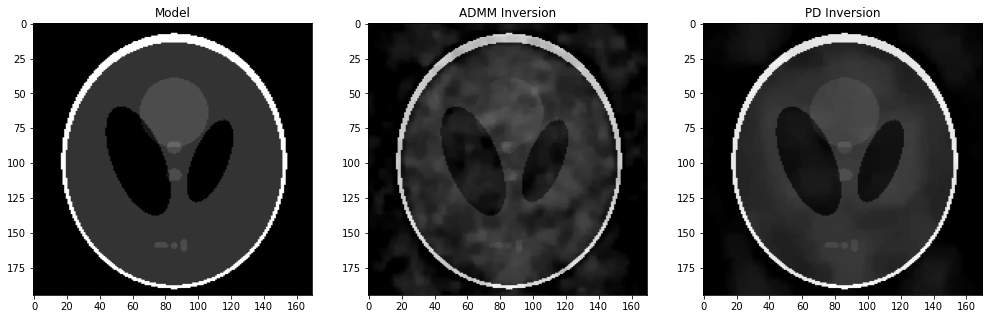

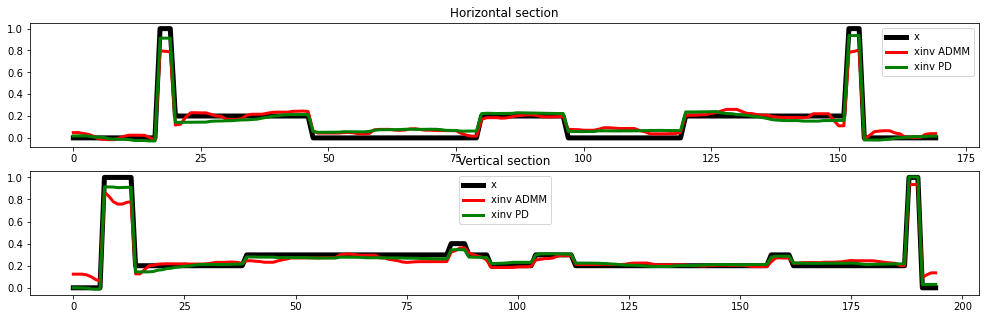

In [3]:
l2 = L2(Op=Rop * Fop, b=y.ravel(), niter=50, warm=True)
Gop = Gradient(dims=x.shape, edge=True, kind='forward', dtype=np.complex)

# Anisotropic TV
sigma = 1e-2
l1 = L1(sigma=sigma)

# Isotropic
#sigma = 1e-2
#l1 = L21(ndim=2, sigma=sigma)

L = 8 #np.real((Gop.H*Gop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = tau / L
xladmm = LinearizedADMM(l2, l1, Gop, tau=tau, mu=mu, x0=np.zeros(x.size, dtype=np.complex), 
                        niter=100, show=True)[0]
xladmm = np.real(xladmm.reshape(x.shape))

tau = .99 / np.sqrt(L)
mu = .99 / np.sqrt(L)
xpd = PrimalDual(l2, l1, Gop, x0=np.zeros(x.size, dtype=np.complex), tau=tau, mu=mu, theta=1., niter=100, show=True)
xpd = np.real(xpd.reshape(x.shape))


fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(xladmm, vmin=0, vmax=1, cmap="gray")
axs[1].set_title("ADMM Inversion")
axs[1].axis("tight")
axs[2].imshow(xpd, vmin=0, vmax=1, cmap="gray")
axs[2].set_title("PD Inversion")
axs[2].axis("tight")


fig, axs = plt.subplots(2, 1, figsize=(17, 5))
axs[0].plot(x[ny // 2], "k", lw=5, label="x")
axs[0].plot(xladmm[ny // 2], "r", lw=3, label="xinv ADMM")
axs[0].plot(xpd[ny // 2], "g", lw=3, label="xinv PD")

axs[0].set_title("Horizontal section")
axs[0].legend()
axs[1].plot(x[:, nx // 2], "k", lw=5, label="x")
axs[1].plot(xladmm[:, nx // 2], "r", lw=3, label="xinv ADMM")
axs[1].plot(xpd[:, nx // 2], "g", lw=3, label="xinv PD")
axs[1].set_title("Vertical section")
axs[1].legend();

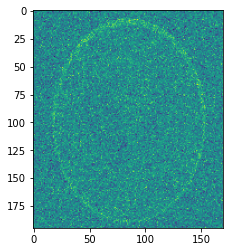

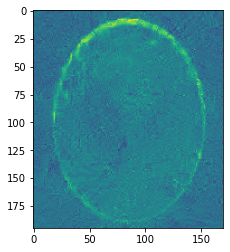

In [4]:
import bm3d

xn = x + np.random.normal(0,1,x.shape)
denoised_image = bm3d.bm3d(xn, sigma_psd=.8, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

plt.figure()
plt.imshow(xn)

plt.figure()
plt.imshow(denoised_image)

In [5]:
import bm3d
from pyproximal.ProxOperator import _check_tau
from pyproximal import ProxOperator
from pyproximal.projection import BoxProj


class BM3D(ProxOperator):
    r"""BM3D

    """
    def __init__(self, dims, sigma=1.):
        super().__init__(None, False)
        self.dims = dims
        self.sigma = sigma
    
    def __call__(self, x):
        return 0.
    
    @_check_tau
    def prox(self, x, tau):
        x = x.reshape(self.dims)
        xden = bm3d.bm3d(x, sigma_psd=self.sigma*tau, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
        return xden.ravel()

ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class '__main__.BM3D'>
tau = 1.000000e+00	niter = 40

   Itn       x[0]          f           g       J = f + g
     1   1.15604e-02   2.216e+02   0.000e+00   2.216e+02
     2  -7.03531e-03   1.146e+02   0.000e+00   1.146e+02
     3  -1.39938e-02   5.296e+01   0.000e+00   5.296e+01
     4  -2.78265e-02   2.380e+01   0.000e+00   2.380e+01
     5  -2.24099e-02   1.124e+01   0.000e+00   1.124e+01
     6  -1.89930e-02   6.033e+00   0.000e+00   6.033e+00
     7  -1.92525e-02   3.882e+00   0.000e+00   3.882e+00
     8  -2.23982e-02   2.922e+00   0.000e+00   2.922e+00
     9  -2.32900e-02   2.447e+00   0.000e+00   2.447e+00
    10  -2.34597e-02   2.183e+00   0.000e+00   2.183e+00
    13  -2.16795e-02   1.841e+00   0.000e+00   1.841e+00
    17  -1.67930e-02   1.626e+00   0.000e+00   1.626e+00
    21  -1.18697e-02   1.520e+00   0.000e+00   1.520e+00
  

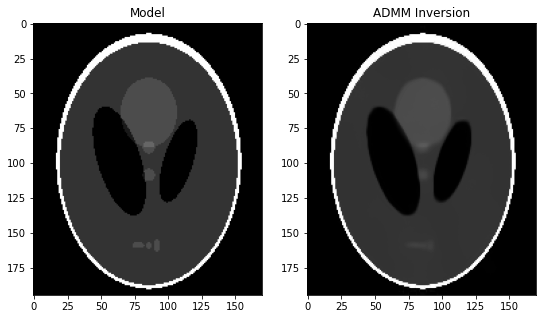

In [6]:
l2 = L2(Op=Rop * Fop, b=y.ravel(), niter=50, warm=True)

# BM3D
sigma = .05
lpnp = BM3D(dims=x.shape, sigma=sigma)

L = 1.
tau = 1./L
xpnp = ADMM(l2, lpnp, tau=tau, x0=np.zeros(x.size), 
            niter=40, show=True)[0]
xpnp = np.real(xpnp.reshape(x.shape))

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(xpnp, vmin=0, vmax=1, cmap="gray")
axs[1].set_title("ADMM Inversion")
axs[1].axis("tight");

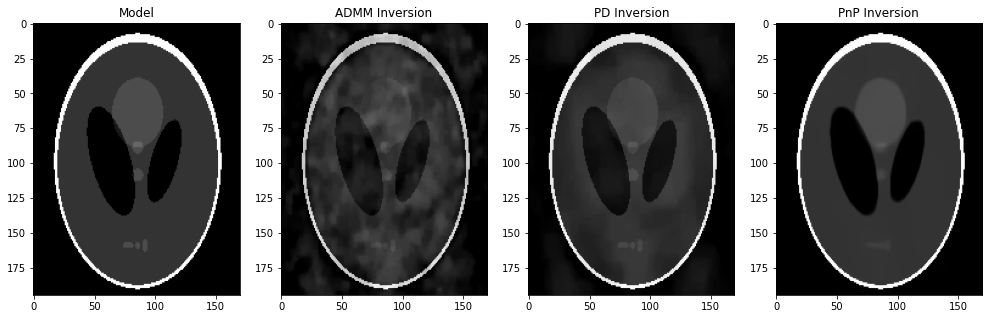

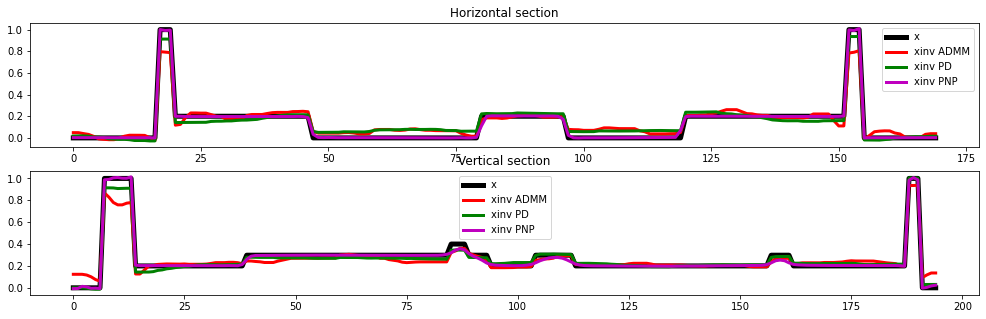

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(17, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(xladmm, vmin=0, vmax=1, cmap="gray")
axs[1].set_title("ADMM Inversion")
axs[1].axis("tight")
axs[2].imshow(xpd, vmin=0, vmax=1, cmap="gray")
axs[2].set_title("PD Inversion")
axs[2].axis("tight")
axs[3].imshow(xpnp, vmin=0, vmax=1, cmap="gray")
axs[3].set_title("PnP Inversion")
axs[3].axis("tight")

fig, axs = plt.subplots(2, 1, figsize=(17, 5))
axs[0].plot(x[ny // 2], "k", lw=5, label="x")
axs[0].plot(xladmm[ny // 2], "r", lw=3, label="xinv ADMM")
axs[0].plot(xpd[ny // 2], "g", lw=3, label="xinv PD")
axs[0].plot(xpnp[ny // 2], "m", lw=3, label="xinv PNP")
axs[0].set_title("Horizontal section")
axs[0].legend()
axs[1].plot(x[:, nx // 2], "k", lw=5, label="x")
axs[1].plot(xladmm[:, nx // 2], "r", lw=3, label="xinv ADMM")
axs[1].plot(xpd[:, nx // 2], "g", lw=3, label="xinv PD")
axs[1].plot(xpnp[:, nx // 2], "m", lw=3, label="xinv PNP")
axs[1].set_title("Vertical section")
axs[1].legend();

In [8]:
def snr(x, xest):
    return 20 * np.log( np.linalg.norm(x) / np.linalg.norm(x-xest))

In [9]:
print(snr(x,xladmm), snr(x,xpd), snr(x,xpnp))

24.678585650154098 35.30853833991115 61.782377348460145


In [10]:
def callback(x, xtrue, xhist, errhist):
    xhist.append(x)
    errhist.append(np.linalg.norm(x - xtrue))

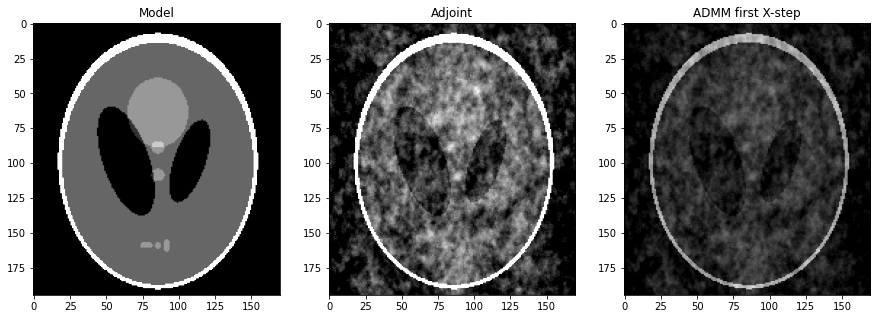

In [20]:
# First step prior to the denoise
Op = Rop * Fop
l2 = L2(Op=Op, b=y.ravel(), niter=50, warm=True)

xadj = np.real(Op.H * y.ravel()).reshape(x.shape)
x1 = np.real(l2.prox(np.zeros_like(x).ravel(), tau).reshape(x.shape))


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(x, vmin=0, vmax=0.5, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(xadj, vmin=0, vmax=0.5, cmap="gray")
axs[1].set_title("Adjoint")
axs[1].axis("tight");
axs[2].imshow(x1, vmin=0, vmax=0.5, cmap="gray")
axs[2].set_title("ADMM first X-step")
axs[2].axis("tight");

ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.optimization.pnp._Denoise'>
tau = 1.000000e+00	niter = 40

   Itn       x[0]          f           g       J = f + g
     1   1.15604e-02   2.216e+02   0.000e+00   2.216e+02
     2  -7.03531e-03   1.146e+02   0.000e+00   1.146e+02
     3  -1.39938e-02   5.296e+01   0.000e+00   5.296e+01
     4  -2.78265e-02   2.380e+01   0.000e+00   2.380e+01
     5  -2.24099e-02   1.124e+01   0.000e+00   1.124e+01
     6  -1.89930e-02   6.033e+00   0.000e+00   6.033e+00
     7  -1.92525e-02   3.882e+00   0.000e+00   3.882e+00
     8  -2.23982e-02   2.922e+00   0.000e+00   2.922e+00
     9  -2.32900e-02   2.447e+00   0.000e+00   2.447e+00
    10  -2.34597e-02   2.183e+00   0.000e+00   2.183e+00
    13  -2.16795e-02   1.841e+00   0.000e+00   1.841e+00
    17  -1.67930e-02   1.626e+00   0.000e+00   1.626e+00
    21  -1.18697e-02   1.520e+00   0

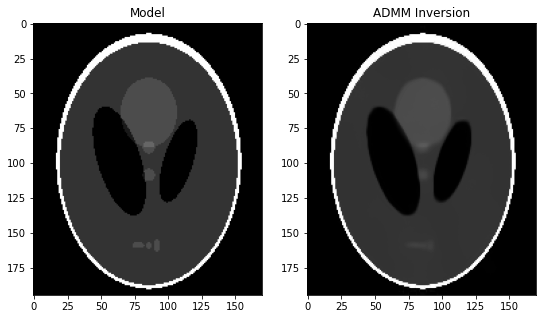

In [35]:
from pyproximal.optimization.pnp import PlugAndPlay

Op = Rop * Fop
l2 = L2(Op=Op, b=y.ravel(), niter=50, warm=True)

# BM3D
sigma = 0.05
denoiser = lambda x, tau: bm3d.bm3d(x, sigma_psd=sigma*tau, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

L = np.real((Op.H*Op).eigs(neigs=1, which='LM')[0])
tau = 1./L
xhist, errhist = [], []
xpnp = PlugAndPlay(l2, denoiser, x.shape, tau=tau, x0=np.zeros(x.size), 
                   niter=40, show=True, callback=lambda xx: callback(xx, x.ravel(), xhist, errhist))[0]
xpnp = np.real(xpnp.reshape(x.shape))

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(xpnp, vmin=0, vmax=1, cmap="gray")
axs[1].set_title("ADMM Inversion")
axs[1].axis("tight");

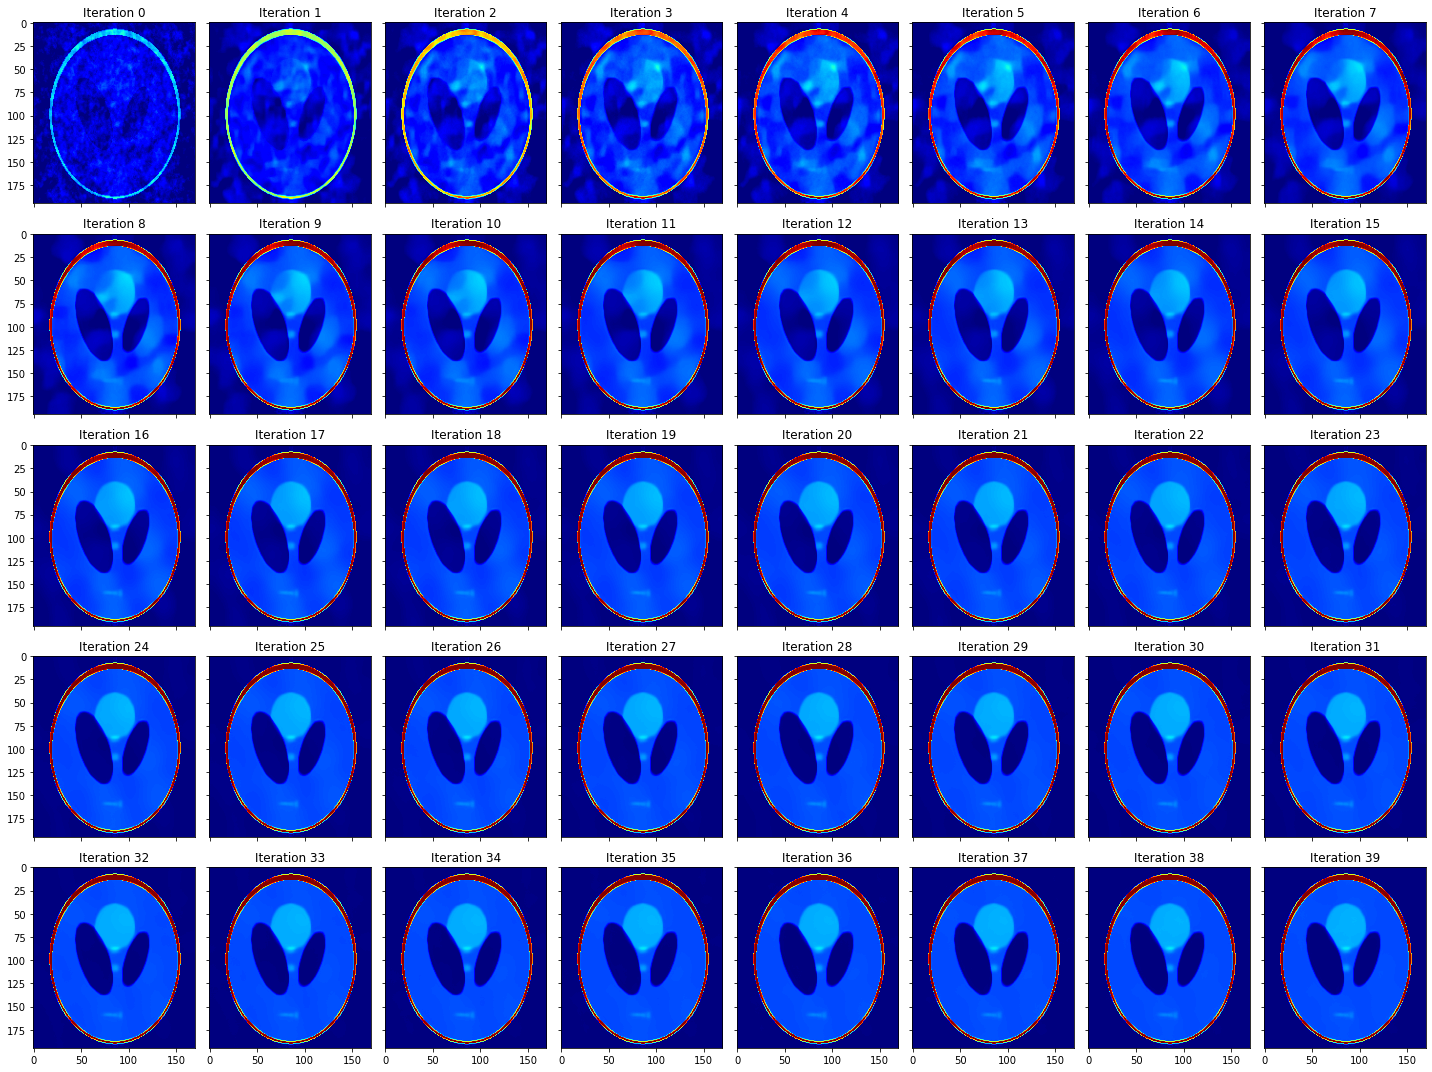

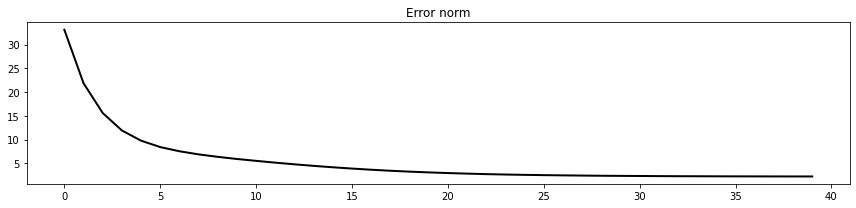

In [36]:
fig, axs = plt.subplots(5, 8, sharex=True, sharey=True, figsize=(20, 15))
axs = axs.ravel()

for i in range(40):
    axs[i].imshow(np.real(xhist[i]).reshape(x.shape), vmin=0, vmax=1, cmap="jet")
    axs[i].set_title('Iteration %d' %i)
    axs[i].axis('tight')
fig.tight_layout()
    
plt.figure(figsize=(12, 3))
plt.plot(errhist, 'k', lw=2)
plt.title("Error norm")
plt.tight_layout()

In [34]:
print(snr(x,xladmm), snr(x,xpd), snr(x,xpnp))

24.678585650154098 35.30853833991115 61.782377348460145


TO DO: Make PnP algorithm that takes as input a denoiser lambda x,tau : denoiser(x,tau,etc...) and then make a Denoiser template class inside that uses this...